In [1]:
import numpy as np
from sklearn.datasets import load_breast_cancer, load_iris

# Iris

### Load Iris dataset

In [2]:
iris = load_iris()

### Implement Naive Bayes classifier

In [3]:
class MyGaussianNB:
    def __init__(self):
        pass

    def fit(self, X, y):
        self.class_labels, self.class_counts = np.unique(y, return_counts=True)
        self.class_priors = np.log(self.class_counts / self.class_counts.sum())

        class_means = []
        class_variance = []
        for label in self.class_labels:
            current_X = X[np.where(y == label)]
            mean = np.mean(current_X, axis=0,keepdims=False)
            double_variance = np.var(current_X, axis=0)
            class_means.append(mean)
            class_variance.append(double_variance)

        self.class_means = np.array(class_means)
        self.class_variance = 2 * np.array(class_variance)
        self.class_variance[np.where(self.class_variance==0)] += 1e-9

    def predict(self, X):

        # for proper broadcasting and optimal numpy we need to extend dimensions
        means = self.class_means[None, :, :]
        variances = self.class_variance[None, :, :]

        with warnings.catch_warnings():
            # suppress 0 division warnings I guess
            warnings.simplefilter("ignore")
            norms = np.log(
                np.exp(-np.square(X[:, None, :] - means) / (variances))
                / np.sqrt(np.pi * variances)
            )   

        probas = norms.sum(axis=-1) + self.class_priors

        return self.class_labels[probas.argmax(axis=-1)]

### Check the results of naive bayes classifier

In [4]:
from sklearn.metrics import accuracy_score, f1_score, precision_score
from sklearn.model_selection import train_test_split
from sklearn.naive_bayes import GaussianNB
import warnings

my_pred = []
sklearn_pred = []
actual_labels = []

for i in range(20):
    X_train, X_test, y_train, y_test = train_test_split(
        iris["data"],
        iris["target"],
        train_size=0.6,
        stratify=iris["target"],
        random_state=i,
    )

    actual_labels.append(y_test)

    clf_mine = MyGaussianNB()
    clf_mine.fit(X_train, y_train)
    my_pred.append(clf_mine.predict(X_test))

    clf_sklearn = GaussianNB()
    clf_sklearn.fit(X_train, y_train)

    sklearn_pred.append(clf_sklearn.predict(X_test))

my_pred = np.concatenate(my_pred)
sklearn_pred = np.concatenate(sklearn_pred)
actual_labels = np.concatenate(actual_labels)

In [5]:
print(f"my acc       : {accuracy_score(my_pred,actual_labels)}")
print(f"my f1        : {f1_score(my_pred,actual_labels,average=None)}")
print(f"my prec      : {precision_score(my_pred,actual_labels,average=None)}")
print()
print(f"sklearn acc  : {accuracy_score(sklearn_pred,actual_labels)}")
print(f"sklearn f1   : {f1_score(sklearn_pred,actual_labels,average=None)}")
print(f"sklearn prec : {precision_score(sklearn_pred,actual_labels,average=None)}")
print()
score_match = (my_pred == sklearn_pred).mean() * 100
print(f"Results of custom and library classifiers match in {score_match}%")

my acc       : 0.96
my f1        : [1.         0.94014963 0.93984962]
my prec      : [1.     0.9425 0.9375]

sklearn acc  : 0.96
sklearn f1   : [1.         0.94014963 0.93984962]
sklearn prec : [1.     0.9425 0.9375]

Results of custom and library classifiers match in 100.0%


The scores returned by my classifier are identical to those returned by scikit-learn GaussianNB

# Breast Cancer

### Load and split the breast cancer dataset

In [6]:
breast_cancer = load_breast_cancer()

In [7]:
X_train, X_test, y_train, y_test = train_test_split(
    breast_cancer["data"], breast_cancer["target"],
    train_size=0.7,
    stratify=breast_cancer["target"],
    random_state=42,
)

### Standardization

In [8]:
clf = MyGaussianNB()
clf.fit(X_train,y_train)
y_pred = clf.predict(X_test)

reference_accuracy = accuracy_score(y_pred,y_test)
reference_f1 = f1_score(y_pred,y_test)
reference_precision = precision_score(y_pred,y_test)

print(f"acc  : {accuracy_score(y_pred,y_test)}")
print(f"f1   : {f1_score(y_pred,y_test)}")
print(f"prec : {precision_score(y_pred,y_test)}")

acc  : 0.935672514619883
f1   : 0.9493087557603687
prec : 0.9626168224299065


In [9]:
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import StandardScaler

clf = Pipeline([("scaler",StandardScaler()),("nb",MyGaussianNB())])

clf.fit(X_train,y_train)
y_pred = clf.predict(X_test)

print(f"acc  : {accuracy_score(y_pred,y_test)}")
print(f"f1   : {f1_score(y_pred,y_test)}")
print(f"prec : {precision_score(y_pred,y_test)}")

acc  : 0.935672514619883
f1   : 0.9493087557603687
prec : 0.9626168224299065


It's a well known fact that naive bayes is not impacted by scaling as the features create independent distributions

### PCA

In [10]:
best_accuracy_grid = "baseline"
best_f1_grid = "baseline"
best_precision_grid = "baseline"

best_accuracy = reference_accuracy
best_f1 = reference_f1
best_precision = reference_precision

In [11]:
from sklearn.decomposition import PCA
from sklearn.model_selection import ParameterGrid

# PCA requires standardization
clf = Pipeline([("scaler",StandardScaler()),("pca",PCA()),("nb",MyGaussianNB())])

param_grid = {
    "pca__n_components":[25,20,15,10,5],
}

for grid in ParameterGrid(param_grid):
    clf.set_params(**grid)

    clf.fit(X_train,y_train)
    y_pred = clf.predict(X_test)
    
    accuracy_ = accuracy_score(y_pred,y_test)
    f1_ = f1_score(y_pred,y_test)
    precision_ = precision_score(y_pred,y_test)
    
    if accuracy_ >= best_accuracy:
        best_accuracy_grid = grid
        best_accuracy = accuracy_
    
    if f1_ >= best_f1:
        best_f1_grid = grid
        best_f1 = f1_
    
    if precision_ >= best_precision:
        best_precision_grid = grid
        best_precision = precision_

print(f"grid for best accuracy  ({best_accuracy}) : \n {best_accuracy_grid}")
print(f"grid for best f1        ({best_f1}) : \n {best_f1_grid}")
print(f"grid for best precision ({best_precision}) : \n {best_precision_grid}")

grid for best accuracy  (0.935672514619883) : 
 {'pca__n_components': 5}
grid for best f1        (0.9502262443438914) : 
 {'pca__n_components': 5}
grid for best precision (0.9813084112149533) : 
 {'pca__n_components': 5}


We managed to improve the model results by using pca

### Kernel PCA

In [12]:
best_accuracy_grid = "baseline"
best_f1_grid = "baseline"
best_precision_grid = "baseline"

best_accuracy = reference_accuracy
best_f1 = reference_f1
best_precision = reference_precision

In [13]:
from sklearn.decomposition import KernelPCA

# PCA requires standardization
clf = Pipeline([("scaler",StandardScaler()),("pca",KernelPCA()),("nb",MyGaussianNB())])

param_grid = {
    "pca__n_components":[25,20,15,10,5],
    "pca__kernel" : ["linear", "poly", "rbf", "sigmoid", "cosine"]
}

for grid in ParameterGrid(param_grid):
    clf.set_params(**grid)

    clf.fit(X_train,y_train)
    y_pred = clf.predict(X_test)
    
    accuracy_ = accuracy_score(y_pred,y_test)
    f1_ = f1_score(y_pred,y_test)
    precision_ = precision_score(y_pred,y_test)
    
    if accuracy_ >= best_accuracy:
        best_accuracy_grid = grid
        best_accuracy = accuracy_
    
    if f1_ >= best_f1:
        best_f1_grid = grid
        best_f1 = f1_
    
    if precision_ >= best_precision:
        best_precision_grid = grid
        best_precision = precision_

print(f"grid for best accuracy  ({best_accuracy}) : \n {best_accuracy_grid}")
print(f"grid for best f1        ({best_f1}) : \n {best_f1_grid}")
print(f"grid for best precision ({best_precision}) : \n {best_precision_grid}")

grid for best accuracy  (0.9473684210526315) : 
 {'pca__kernel': 'cosine', 'pca__n_components': 10}
grid for best f1        (0.958904109589041) : 
 {'pca__kernel': 'cosine', 'pca__n_components': 10}
grid for best precision (0.9813084112149533) : 
 {'pca__kernel': 'cosine', 'pca__n_components': 10}


We managed to significantly improve the scores using Kernel PCA with cosine kernel and 10 components

### Implement custom Box-Cox transformer to work with multiple lambdas

In [14]:
class MyBoxCox:
    def __init__(self, lambdas = None):
        if not hasattr(lambdas, '__iter__'):
            lambdas = [lambdas]
        self.lambdas = lambdas
        
    def get_params(self,deep):
        return {"lambdas":self.lambdas}
        
    def _single_transform(self,X, lmbd):
        if lmbd == 0:
            return np.log(X)
        else:
            return (np.power(X, lmbd) - 1) / lmbd
    
    def fit_transform(self, X, y = None):
        self.minimum_abs = []
        
        for lmbd in self.lambdas:
            abs4lmbd = np.abs(X.min()) +  1e-10
            self.minimum_abs.append(abs4lmbd)
            X = self._single_transform(X+abs4lmbd,lmbd) 
        return X

    def transform(self, X):
        for lmbd, abs4lmbd in zip(self.lambdas, self.minimum_abs):
            self.minimum_abs.append(abs4lmbd)
            X = self._single_transform(X+abs4lmbd,lmbd) 
        return X

In [15]:
best_accuracy_grid = "baseline"
best_f1_grid = "baseline"
best_precision_grid = "baseline"

best_accuracy = reference_accuracy
best_f1 = reference_f1
best_precision = reference_precision

In [16]:
from sklearn.preprocessing import PowerTransformer

clf = Pipeline([("boxcox",MyBoxCox()),("nb",MyGaussianNB())])

for lambda_param in [[0.0], [0.1], [0.2], [0.3], [0.4], [0.5], [0.6], [0.7], [0.8], [0.9], [1.0]]:
    clf["boxcox"].lambdas = lambda_param

    clf.fit(X_train,y_train)
    y_pred = clf.predict(X_test)

    accuracy_ = accuracy_score(y_pred,y_test)
    f1_ = f1_score(y_pred,y_test)
    precision_ = precision_score(y_pred,y_test)

    if accuracy_ >= best_accuracy:
        best_accuracy_grid = lambda_param
        best_accuracy = accuracy_
    
    if f1_ >= best_f1:
        best_f1_grid = lambda_param
        best_f1 = f1_
    
    if precision_ >= best_precision:
        best_precision_grid = lambda_param
        best_precision = precision_

print(f"lambdas for best accuracy  ({best_accuracy}) : \n {best_accuracy_grid}")
print(f"lambdas for best f1        ({best_f1}) : \n {best_f1_grid}")
print(f"lambdas for best precision ({best_precision}) : \n {best_precision_grid}")

lambdas for best accuracy  (0.9590643274853801) : 
 [0.4]
lambdas for best f1        (0.9674418604651163) : 
 [0.4]
lambdas for best precision (0.9719626168224299) : 
 [0.7]


Using Box-Cox transformation we managed to get the best accuracy and f1 score

# Binomial Distribution NB

In [17]:
class MyBinomialNB:
    def __init__(self,alpha=1.0):
        self.alpha = alpha

    def fit(self, X, y):
        self.class_labels, self.class_counts = np.unique(y, return_counts=True)
        self.class_priors = np.log(self.class_counts / self.class_counts.sum())

        class_probs = []
        for label in self.class_labels:
            current_X = X[np.where(y == label)]
            
            # laplace smoothing (x.sum()+1)/(|x|+2) instead of x.sum()/|x|
            theta = (np.sum(current_X, axis=0) + self.alpha) / (current_X.shape[0] + self.alpha*2) 
            class_probs.append(np.array(theta).flatten())

        # Thetas
        self.class_probs = np.array(class_probs)

    def predict(self, X):    
        log_prob_1 = np.log(self.class_probs)[None, :, :]
        log_prob_0 = np.log(1 - self.class_probs)[None, :, :]
        
        likelyhoods = X.dot(log_prob_1[0].T) + (1 - X.todense()).dot(log_prob_0[0].T)
        
        probas = np.array(likelyhoods + self.class_priors)

        return self.class_labels[probas.argmax(axis=-1)]

### 20 news groups

In [18]:
from sklearn.datasets import fetch_20newsgroups_vectorized

In [19]:
news_train = fetch_20newsgroups_vectorized(subset="train")
news_test = fetch_20newsgroups_vectorized(subset="test")

X_train = news_train["data"] > 0
y_train = news_train["target"]

X_test = news_test["data"] > 0
y_test = news_test["target"]

In [20]:
from sklearn.naive_bayes import BernoulliNB

bernoulli_sklearn = BernoulliNB()
bernoulli_sklearn.fit(X_train,y_train)
sklearn_pred = bernoulli_sklearn.predict(X_test)

accuracy_score(sklearn_pred,y_test)

0.6307753584705258

In [21]:
bernoulli_mine = MyBinomialNB()
bernoulli_mine.fit(X_train,y_train)
my_pred = bernoulli_mine.predict(X_test)

accuracy_score(my_pred,y_test)

0.6307753584705258

In [22]:
score_match = (my_pred == sklearn_pred).mean() * 100
print(f"Results of custom and library classifiers match in {score_match}%")

Results of custom and library classifiers match in 100.0%


But the implementation is suboptimal. It's slow. Takes a good few seconds to compute

# Adult Income dataset

In [23]:
import pandas as pd

In [24]:
adult_df = pd.read_csv("adult.csv")
target = (adult_df.pop("income") == ">50K").values.astype(np.int32)

In [25]:
numerical_features = ["age", "fnlwgt", "educational-num","capital-gain","capital-loss","hours-per-week"]
categorical_features = [name for name in adult_df.columns if name not in numerical_features]

In [26]:
from sklearn.compose import ColumnTransformer
from sklearn.preprocessing import OneHotEncoder, MinMaxScaler

accuracy = []
f1 = []
precision = []

for i in range(50):
    X_train, X_test, y_train, y_test = train_test_split(adult_df,target,train_size=0.7,random_state=i,stratify=target)
    
    column_transformer = ColumnTransformer(
        [
            ("categorical", OneHotEncoder(handle_unknown="ignore"), categorical_features),
            ("numerical", MyBoxCox([0.1]), numerical_features),
        ]
    )
    
    X_train = np.asarray(column_transformer.fit_transform(X_train).todense())
    X_test = np.asarray(column_transformer.transform(X_test).todense())
    
    clf = MyGaussianNB()
    clf.fit(X_train,y_train)
    y_pred = clf.predict(X_test)
    
    accuracy.append(accuracy_score(y_pred,y_test))
    f1.append(f1_score(y_pred,y_test))
    precision.append(precision_score(y_pred,y_test))

accuracy = np.array(accuracy)
f1 = np.array(f1)
precision = np.array(precision)

In [27]:
accuracy.mean(), f1.mean(), precision.mean()

(0.5912823312632226, 0.5202520890409829, 0.9248545350827153)

In [28]:
accuracy.std(), f1.std(), precision.std()

(0.0230140702694564, 0.011644302996915934, 0.009790537102816016)

The results aren't great and improving them proved to be difficult

# Linear Regressor

In [29]:
import scipy.stats as stats

class BayesianLinearRegression:
    def __init__(self, n_features, alpha, beta):
        self.n_features = n_features
        self.alpha = alpha
        self.beta = beta
        self.mean = np.zeros(n_features)
        self.cov = np.identity(n_features) * alpha
    
    def learn(self, x, y):
        # Update the inverse covariance matrix
        cov_inv = np.linalg.inv(self.cov) + self.beta * np.outer(x, x)
        self.cov = np.linalg.inv(cov_inv)
        
        # Update the mean vector
        self.mean = self.cov @ (cov_inv @ self.mean + self.beta * y * x)
        
        return self
    
    def predict(self, x):
        # Obtain the predictive mean
        y_pred_mean = x @ self.mean        
        
        # Obtain the predictive variance
        y_pred_var = 1 / self.beta + x @ self.cov @ x.T

        return stats.norm(loc=y_pred_mean, scale=y_pred_var ** 0.5)
    
    @property
    def weights_dist(self):
        return stats.multivariate_normal(mean=self.mean, cov=self.cov)   


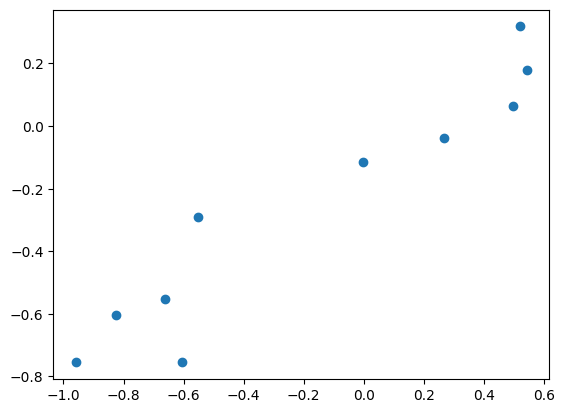

In [30]:
import matplotlib.pyplot as plt

w = 0.6
b = -0.2
low_bound = -1
high_bound = 1

np.random.seed(10)
n_samples = 10
X = np.random.uniform(low_bound, high_bound,size=n_samples)
y = b + w*X +  np.random.normal(0, 0.2,size=n_samples)

plt.scatter(X,y)

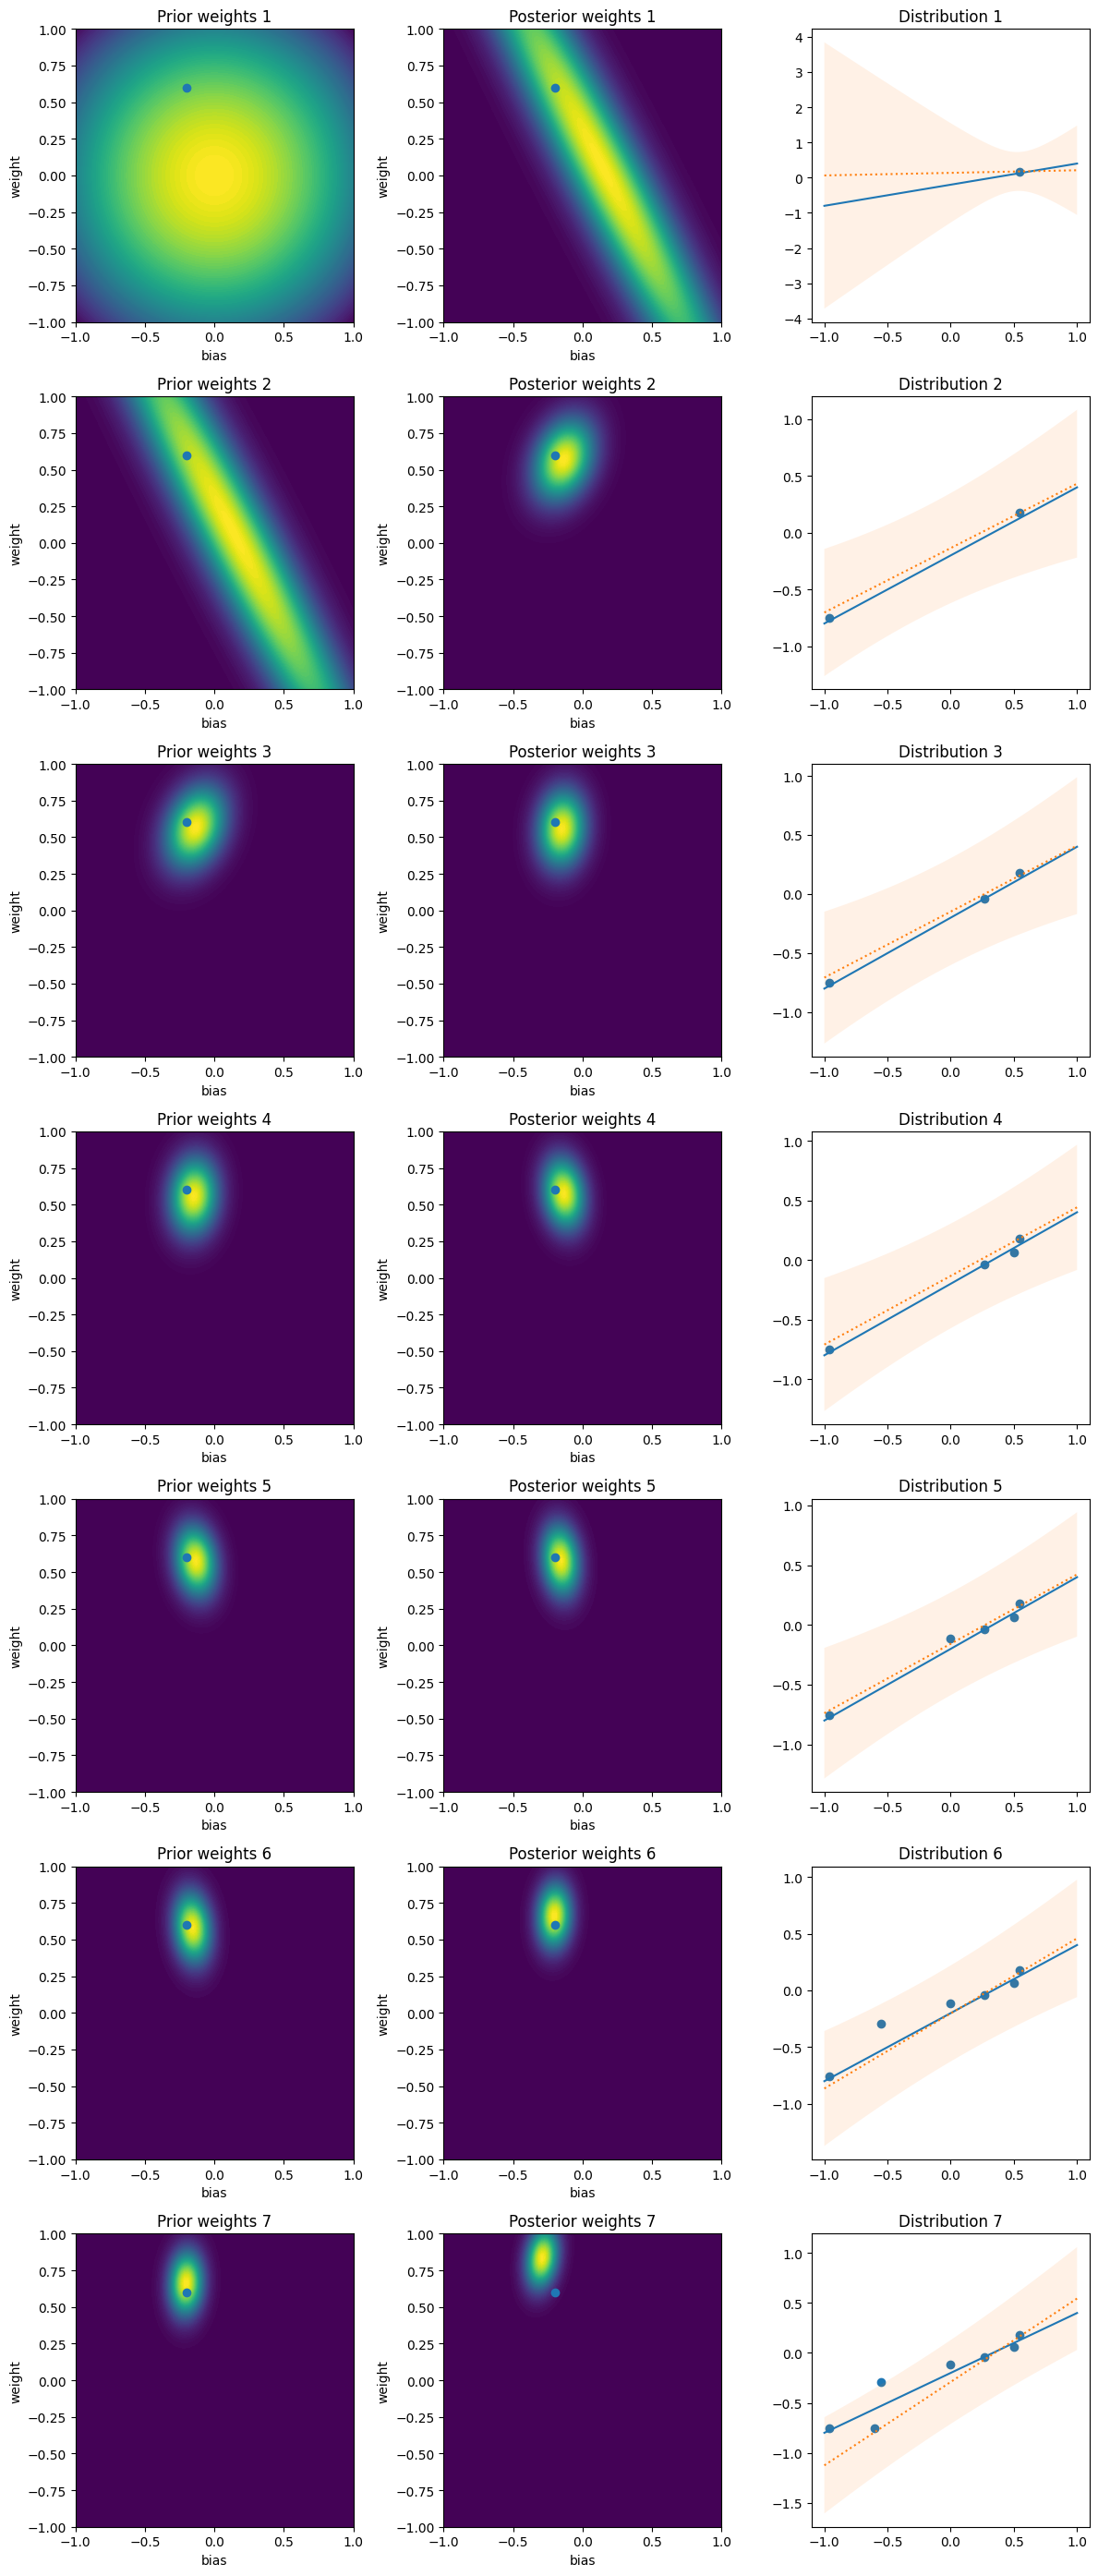

In [31]:
model = BayesianLinearRegression(n_features=2, alpha=2, beta=25)

plot_res = 100
bounds = np.linspace(low_bound, high_bound, plot_res)
W = np.repeat(bounds[None,:],bounds.shape[0],axis=0)
W = np.dstack([W,W.T])

figure, axis = plt.subplots(7,3, figsize=(12,28))

for i, (xi, yi) in enumerate(zip(X[:7],y[:7])):
    
    axis[i,0].set_title(f'Prior weights {i + 1}')
    axis[i,0].set_ylabel("weight")
    axis[i,0].set_xlabel("bias")
    axis[i,0].contourf(bounds, bounds, model.weights_dist.pdf(W), plot_res)
    axis[i,0].scatter(b,w)
    
    model.learn(np.array([1,xi]), yi)
    
    axis[i,1].set_title(f'Posterior weights {i + 1}')
    axis[i,1].set_ylabel("weight")
    axis[i,1].set_xlabel("bias")
    axis[i,1].contourf(bounds, bounds, model.weights_dist.pdf(W), plot_res)
    axis[i,1].scatter(b,w)
    
    posteriors = [model.predict(np.array([1, x_])) for x_ in bounds]
    cis = [p.interval(0.95) for p in posteriors]
    bound_values = [model.predict(np.array([1, low_bound])).mean(),model.predict(np.array([1, high_bound])).mean()]
    
    axis[i,2].set_title(f'Distribution {i + 1}')
    axis[i,2].plot(bounds, [b + w * x_ for x_ in bounds])  # plot the actual function
    axis[i,2].scatter(X[:i+1], y[:i+1]) # plot points
    # axis[i,2].plot(bounds, [p.mean() for p in posteriors], linestyle=':') # predicted function
    axis[i,2].plot([low_bound,high_bound], bound_values, linestyle=':') # predicted function
    axis[i,2].fill_between(
        x=bounds,
        y1=[ci[0] for ci in cis],
        y2=[ci[1] for ci in cis],
        alpha=.1
    )

plt.tight_layout()
plt.show()

We can see how outliers can impact performance of such model